In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf

#import rpy2.robjects.robject as r

In [2]:
DIR_DATA = '/global/homes/c/czarakas/TREE2H2O/stomatal_slope_experiments/data_analysis/stomatal_slope_ranges/'
fname = 'WUEdatabase_merged_Lin_et_al_2015_NCC.csv'

# Load data

In [23]:
df = pd.read_csv(DIR_DATA+fname, encoding = "ISO-8859-1")

In [24]:
for col in df.columns:
    print(col)

Pathway
Type
Plantform
Leafspan
Tregion
Wregion
Wregion2
opt
Species
CO2S
Datacontrib
Growthcond
Trmmol
PARin
Location
latitude
longitude
Tleaf
Cond
Photo
VPD


### Qualitative Variables:
* Pathway (C3 or C4)
* Type (angiosperm or gymnosperm)
* Plantform (tree, shrub, savanna, grass, crop)
* Leafspan (deciduous, evergreen)
* Tregion (boreal, temperate, Arctic, tropical)
* Wregion (humid, dry sub-humid, arid, semi-arid, semi_arid)
* Growthcond (field, Field, OTC, WTC, FACE, OTC O3, OTC field)
* Datacontrib (name of data contributor)
* Location (name of location)
* Species (species name)
* opt

### Quantitative Variables:
* Wregion2
* latitude
* longitude
* Trmmol
* PARin
* Tleaf
* CO2S
* Cond
* Photo
* VPD

# Process data

In [91]:
def calc_sat_vapor_pressure(temp_C):
    # Equation from equation 17 in Huang et al, 2018
    term1 = 34.494-(4924.99/(temp_C+237.1))
    term2 = (temp_C+105)**1.57
    return (np.exp(term1)/term2)/1000

In [92]:
df['Tleaf']=np.where(df['Tleaf']>-9999,df['Tleaf'], np.nan)

# calculate saturation vapor pressure based on leaf temperature
df['Saturation_Vapor_Presure_kPa']=calc_sat_vapor_pressure(df.Tleaf)

# calculate vapor pressure (using sat. vapor pressure and VPD)
df['Vapor_Presure_kPa'] = df['Saturation_Vapor_Presure_kPa']-df.VPD

# drop observations where vapor pressure from this calculation is negative
df['Vapor_Presure_kPa'] = np.where(df['Vapor_Presure_kPa']>=0, df['Vapor_Presure_kPa'], np.nan)

# calculate relative humidity
df['RH_frac']=df['Vapor_Presure_kPa']/df['Saturation_Vapor_Presure_kPa']

# drop RH where RH < 0 (this shouldn't be possible)
df['RH_frac']=np.where(df['RH_frac']>=0, df['RH_frac'], np.nan)

In [93]:
g0 = 0
df['xvals_BB']=df['Photo']*df['RH_frac']/df['CO2S']
df['yvals_BB']=df['Cond']- g0 

In [94]:
PFT_categories=["Evergreen needleleaf", "Evergreen broadleaf", "Deciduous broadleaf", 
                "Shrub", "C3 grassland", "C4 grassland",  #"Tundra",
                "C3 cropland"]

PFTs = ["NE Temp. Tree", "NE Bor. Tree", "BE Trop. Tree", "BE Temp. Tree", 
        "BD Trop. Tree", "BD Temp. Tree", "BD Bor. Tree",
        "BE Shrub", "BD Temp. Shrub", "BD Bor. Shrub",
        "C3 Grass", "C4 grass",
        "C3 Crop"]

PFT_nums = [1, 2, 4, 5,
           6, 7, 8,
           9, 10, 11, 
           13, 14,
           15] # note no observations in Lin et al. for PFT #3 or #12

In [95]:
df['PFT_category'] = ''
df['PFT_num'] = 0

### Classify observations

Assign each observation to a PFT category (used in De Kauwe et al. 2015 and CLM5)

In [96]:
df.loc[df['Type']=='gymnosperm', ['PFT_category']] = "Evergreen needleleaf"
df.loc[(df['Plantform']=='tree') & (df['Type']=='angiosperm') & (df['Leafspan']=='evergreen'), ['PFT_category']] = "Evergreen broadleaf"
df.loc[(df['Plantform']=='tree') & (df['Type']=='angiosperm') & (df['Leafspan']=='deciduous'), ['PFT_category']] = "Deciduous broadleaf"
df.loc[(df['Plantform']=='savanna') & (df['Type']=='angiosperm') & (df['Leafspan']=='evergreen'), ['PFT_category']] = "Evergreen broadleaf"
df.loc[(df['Plantform']=='savanna') & (df['Type']=='angiosperm') & (df['Leafspan']=='deciduous'), ['PFT_category']] = "Deciduous broadleaf"
df.loc[df['Plantform']=='shrub', ['PFT_category']] = "Shrub"
# df.loc[df['Tregion']=='Arctic', ['PFT_category']] = "Tundra" # Note that this was based off DeKauwe et al. which had an Arctic PFT
df.loc[(df['Plantform']=='grass') & (df['Pathway']=='C3'), ['PFT_category']] = "C3 grassland"
df.loc[(df['Plantform']=='grass') & (df['Pathway']=='C4'), ['PFT_category']] = "C4 grassland"
df.loc[(df['Plantform']=='crop') & (df['Pathway']=='C3'), ['PFT_category']] = "C3 cropland"
df.loc[(df['Plantform']=='crop') & (df['Pathway']=='C4'), ['PFT_category']] = "C4 cropland"

Assign each observation to a CLM5 PFT (narrower classification than above)

In [97]:
df.loc[(df['Type']=='gymnosperm') & (df['Tregion']=='temperate'), ['PFT_num']] = 1
df.loc[(df['Type']=='gymnosperm') & (df['Tregion']=='boreal'), ['PFT_num']] = 2
df.loc[(df['Plantform']=='tree') & (df['Type']=='angiosperm') & (df['Leafspan']=='evergreen') & (df['Tregion']=='tropical'), ['PFT_num']] = 4
df.loc[(df['Plantform']=='savanna') & (df['Type']=='angiosperm') & (df['Leafspan']=='evergreen') & (df['Tregion']=='tropical'), ['PFT_num']] = 4
df.loc[(df['Plantform']=='tree') & (df['Type']=='angiosperm') & (df['Leafspan']=='evergreen') & (df['Tregion']=='temperate'), ['PFT_num']] = 5
df.loc[(df['Plantform']=='savanna') & (df['Type']=='angiosperm') & (df['Leafspan']=='evergreen') & (df['Tregion']=='temperate'), ['PFT_num']] = 5
df.loc[(df['Plantform']=='tree') & (df['Type']=='angiosperm') & (df['Leafspan']=='deciduous') & (df['Tregion']=='tropical'), ['PFT_num']] = 6
df.loc[(df['Plantform']=='savanna') & (df['Type']=='angiosperm') & (df['Leafspan']=='deciduous') & (df['Tregion']=='tropical'), ['PFT_num']] = 6
df.loc[(df['Plantform']=='tree') & (df['Type']=='angiosperm') & (df['Leafspan']=='deciduous') & (df['Tregion']=='temperate'), ['PFT_num']] = 7
df.loc[(df['Plantform']=='savanna') & (df['Type']=='angiosperm') & (df['Leafspan']=='deciduous') & (df['Tregion']=='temperate'), ['PFT_num']] = 7
df.loc[(df['Plantform']=='tree') & (df['Type']=='angiosperm') & (df['Leafspan']=='deciduous') & (df['Tregion']=='boreal'), ['PFT_num']] = 8
df.loc[(df['Plantform']=='savanna') & (df['Type']=='angiosperm') & (df['Leafspan']=='deciduous') & (df['Tregion']=='boreal'), ['PFT_num']] = 8
df.loc[(df['Plantform']=='shrub') & (df['Leafspan']=='evergreen'), ['PFT_num']] = 9
df.loc[(df['Plantform']=='shrub') & (df['Leafspan']=='deciduous') & (df['Tregion']=='temperate'), ['PFT_num']] = 10
df.loc[(df['Plantform']=='shrub') & (df['Leafspan']=='deciduous') & (df['Tregion']=='boreal'), ['PFT_num']] = 11
df.loc[(df['Plantform']=='shrub') & (df['Leafspan']=='deciduous') & (df['Tregion']=='Arctic'), ['PFT_num']] = 11
df.loc[(df['Plantform']=='grass') & (df['Pathway']=='C3'), ['PFT_num']] = 13
df.loc[(df['Plantform']=='grass') & (df['Pathway']=='C4'), ['PFT_num']] = 14
df.loc[(df['Plantform']=='crop') & (df['Pathway']=='C3'), ['PFT_num']] = 15
df.loc[(df['Plantform']=='crop') & (df['Pathway']=='C4'), ['PFT_num']] = 17

##### Check classifications

In [ ]:
# Check that broad PFT categories make sense
print('PFT Categories')
print(np.unique(df['PFT_category']))
for category_test in PFT_categories:
    print('----------------------')
    print(category_test)
    print('Pathways:   '+str(np.unique(df[df['PFT_category']==category_test]['Pathway'])))
    print('Plantforms: '+str(np.unique(df[df['PFT_category']==category_test]['Plantform'])))
    print('Types:      '+str(np.unique(df[df['PFT_category']==category_test]['Type'])))
    print('Leafspans:  '+str(np.unique(df[df['PFT_category']==category_test]['Leafspan'])))
    print('Tregions:   '+str(np.unique(df[df['PFT_category']==category_test]['Tregion'])))

In [ ]:
# Check that broad PFT categories make sense
print('PFT Numbers: ')
print(np.unique(df['PFT_num']))
for i, category_test in enumerate(np.unique(df['PFT_num'])):
    print('----------------------')
    print(category_test)
    print(PFTs[i])
    print('Pathways:   '+str(np.unique(df[df['PFT_num']==category_test]['Pathway'])))
    print('Plantforms: '+str(np.unique(df[df['PFT_num']==category_test]['Plantform'])))
    print('Types:      '+str(np.unique(df[df['PFT_num']==category_test]['Type'])))
    print('Leafspans:  '+str(np.unique(df[df['PFT_num']==category_test]['Leafspan'])))
    print('Tregions:   '+str(np.unique(df[df['PFT_num']==category_test]['Tregion'])))

# Check distributions of variables

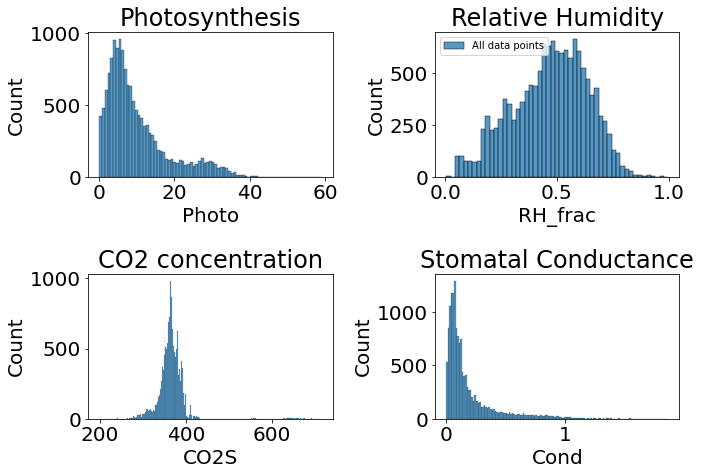

In [109]:
data_filter=df['RH_frac']>0.1
plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
plt.title('Photosynthesis')
sns.histplot(df['Photo'])
plt.subplot(2,2,2)
plt.title('Relative Humidity')
sns.histplot(df['RH_frac'], label='All data points')
plt.legend(fontsize=10)
plt.subplot(2,2,3)
plt.title('CO2 concentration')
sns.histplot(df['CO2S'])
plt.subplot(2,2,4)
plt.title('Stomatal Conductance')
sns.histplot(df['Cond'])
plt.tight_layout()

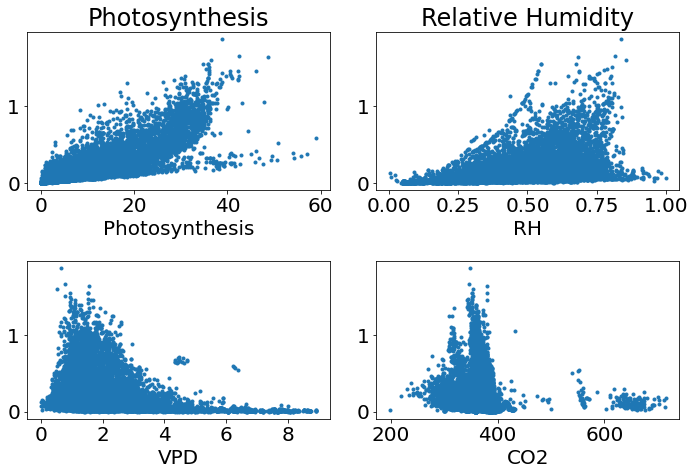

In [114]:
plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
plt.title('Photosynthesis')
plt.plot(df['Photo'],df['Cond'],'.')
plt.xlabel('Photosynthesis')
plt.subplot(2,2,2)
plt.title('Relative Humidity')
plt.plot(df['RH_frac'],df['Cond'],'.')
plt.xlabel('RH')
plt.subplot(2,2,3)
plt.plot(df['VPD'],df['Cond'],'.')
plt.xlabel('VPD')
plt.subplot(2,2,4)
plt.plot(df['CO2S'],df['Cond'],'.')
plt.xlabel('CO2')
plt.tight_layout()

# Calculate stomatal slope for PFTs

In [106]:
df_BB = df[df.xvals_BB>0]
df_BB = df_BB[df_BB.yvals_BB>0]

--------------
Evergreen needleleaf
g1 estimate: 12 species
9.49
--------------
Evergreen broadleaf
g1 estimate: 202 species
11.254
--------------
Deciduous broadleaf
g1 estimate: 19 species
13.685
--------------
Shrub
g1 estimate: 15 species
11.254
--------------
C3 grassland
g1 estimate: 20 species
13.036
--------------
C4 grassland
g1 estimate: 38 species
6.251
--------------
C3 cropland
g1 estimate: 3 species
14.09


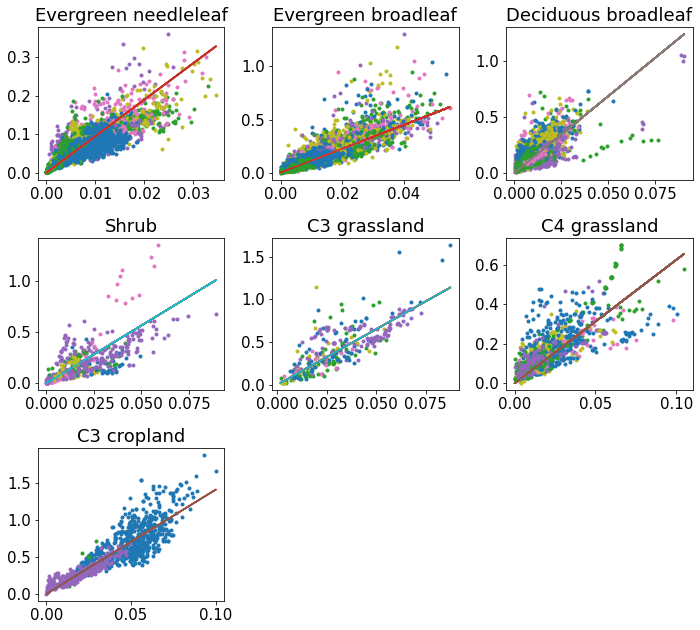

In [104]:
plt.figure(figsize=[10,9])
plt.rcParams.update({'font.size': 15})

# ----------------------- Use this if grouping by PFT category (broader categorization, used in CLM)
# This is the approach we take for selecting range for model experiments
PFT_avgs = np.zeros(np.size(PFT_categories))
for i, PFT_category in enumerate(PFT_categories):
    plt.subplot(3,3,i+1)
    #Subset to single PFT
    df_subset = df_BB[df_BB['PFT_category']==PFT_category]
    plttitle = PFT_category
# ------------------------------------------------------------------------------------------

# ----------------------- Use this if grouping by PFT (more narrow categorization)
#PFT_avgs = np.zeros(np.size(PFT_nums))
#for i, PFT_num in enumerate(PFT_nums):
#    plt.subplot(4,4,i+1)
#    #Subset to single PFT
#    df_subset = df[df['PFT_num']==PFT_num]
#    plttitle=PFTs[i]+' ('+str(PFT_num)+')'
# ------------------------------------------------------------------------------------------

    # Fit mixed effects model (where species is random effect)
    model = smf.mixedlm("yvals_BB ~ xvals_BB-1", df_subset, 
                        groups=df_subset["Species"],
                        re_formula="0 + xvals_BB")
    results = model.fit()
    params = results.params
    predictions = model.predict(params)
    PFT_avgs[i] = params['xvals_BB']

    # Make figure
    
    for species in df_subset['Species'].unique():
        plt.plot(df_subset[df_subset['Species']==species].xvals_BB, 
                 df_subset[df_subset['Species']==species].yvals_BB,'.')
        plt.plot(df_subset["xvals_BB"], predictions)
    plt.title(plttitle)
    
    # Print Summary
    print('--------------')
    print(plttitle)
    print('g1 estimate: '+str(np.size(df_subset['Species'].unique()))+' species')
    print(np.round(PFT_avgs[i],3))
plt.tight_layout()

--------------
Evergreen needleleaf
g1 estimate: 12 species
9.51
--------------
Evergreen broadleaf
g1 estimate: 202 species
11.293
--------------
Deciduous broadleaf
g1 estimate: 19 species
13.714
--------------
Shrub
g1 estimate: 15 species
11.267
--------------
C3 grassland
g1 estimate: 20 species
13.053
--------------
C4 grassland
g1 estimate: 38 species
6.258
--------------
C3 cropland
g1 estimate: 3 species
14.105


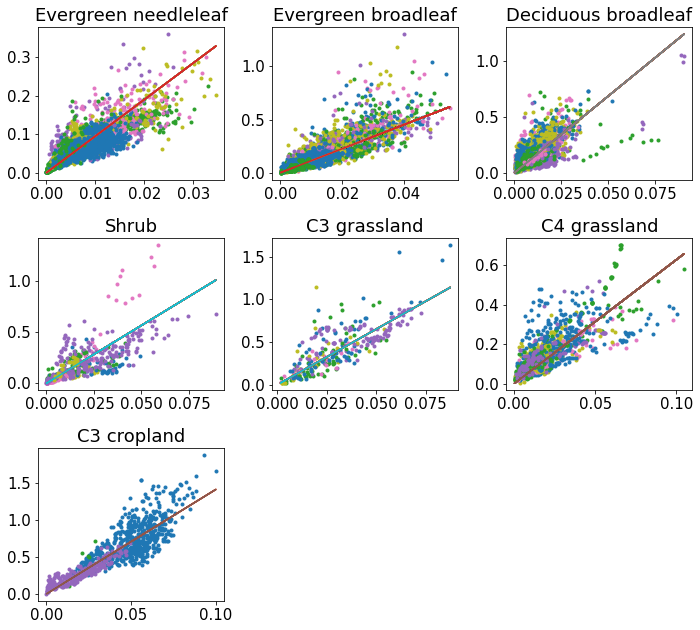

In [15]:
plt.figure(figsize=[10,9])
plt.rcParams.update({'font.size': 15})

# ----------------------- Use this if grouping by PFT category (broader categorization, used in CLM)
# This is the approach we take for selecting range for model experiments
PFT_avgs = np.zeros(np.size(PFT_categories))
for i, PFT_category in enumerate(PFT_categories):
    plt.subplot(3,3,i+1)
    #Subset to single PFT
    df_subset = df_BB[df_BB['PFT_category']==PFT_category]
    plttitle = PFT_category
    
    # Fit mixed effects model (where species is random effect)
    model = smf.mixedlm("yvals_BB ~ xvals_BB-1", df_subset, 
                        groups=df_subset.Species,
                        re_formula="0 + xvals_BB")
    results = model.fit()
    params = results.params
    predictions = model.predict(params)
    PFT_avgs[i] = params['xvals_BB']

    # Make figure
    
    for species in df_subset['Species'].unique():
        plt.plot(df_subset[df_subset['Species']==species].xvals_BB, 
                 df_subset[df_subset['Species']==species].yvals_BB,'.')
        plt.plot(df_subset["xvals_BB"], predictions)
    plt.title(plttitle)
    
    # Print Summary
    print('--------------')
    print(plttitle)
    print('g1 estimate: '+str(np.size(df_subset['Species'].unique()))+' species')
    print(np.round(PFT_avgs[i],3))
plt.tight_layout()

Note: values from Frank et al. 2017 Table II


* Evergreen needleleaf: 7.88
* Evergreen broadleaf: 12.3
* Deciduous broadleaf: 13.1
* Shrub:               13.8
* C3 grassland:        15.1
* C4 grassland:         6.05
* C3 cropland:         16.5
* Arctic tundra:        7.55

# Calculate range of stomatal slope for PFTs

In [34]:
df_BB= df[df.xvals_BB>0]
df_BB = df_BB[df_BB.yvals_BB>0]
df_BB = df_BB[df_BB.RH_frac>0.1]

/global/homes/c/czarakas/.conda/envs/model_analysis/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/global/homes/c/czarakas/.conda/envs/model_analysis/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1673: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/global/homes/c/czarakas/.conda/envs/model_analysis/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1673: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


--------------
Evergreen needleleaf
12 species
0 species w/not enough replicates
4395 measurements counted
0 measurements not counted (b/c not enough replicates)
5th percentile: 5.97
Mean: 9.49
95th percentile: 14.96


/global/homes/c/czarakas/.conda/envs/model_analysis/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/global/homes/c/czarakas/.conda/envs/model_analysis/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--------------
Evergreen broadleaf
202 species
0 species w/not enough replicates
3447 measurements counted
0 measurements not counted (b/c not enough replicates)
5th percentile: 6.98
Mean: 10.62
95th percentile: 18.07
--------------
Deciduous broadleaf
19 species
0 species w/not enough replicates
2729 measurements counted
0 measurements not counted (b/c not enough replicates)
5th percentile: 8.01
Mean: 13.7
95th percentile: 19.47


/global/homes/c/czarakas/.conda/envs/model_analysis/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/global/homes/c/czarakas/.conda/envs/model_analysis/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--------------
Shrub
15 species
0 species w/not enough replicates
686 measurements counted
0 measurements not counted (b/c not enough replicates)
5th percentile: 5.45
Mean: 11.3
95th percentile: 17.01
--------------
C3 grassland
20 species
0 species w/not enough replicates
304 measurements counted
0 measurements not counted (b/c not enough replicates)
5th percentile: 8.67
Mean: 12.86
95th percentile: 18.82


/global/homes/c/czarakas/.conda/envs/model_analysis/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/global/homes/c/czarakas/.conda/envs/model_analysis/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


--------------
C4 grassland
38 species
0 species w/not enough replicates
1153 measurements counted
0 measurements not counted (b/c not enough replicates)
5th percentile: 3.96
Mean: 7.14
95th percentile: 11.21
--------------
C3 cropland
3 species
0 species w/not enough replicates
844 measurements counted
0 measurements not counted (b/c not enough replicates)
5th percentile: 13.33
Mean: 15.86
95th percentile: 19.46


<Figure size 720x576 with 0 Axes>

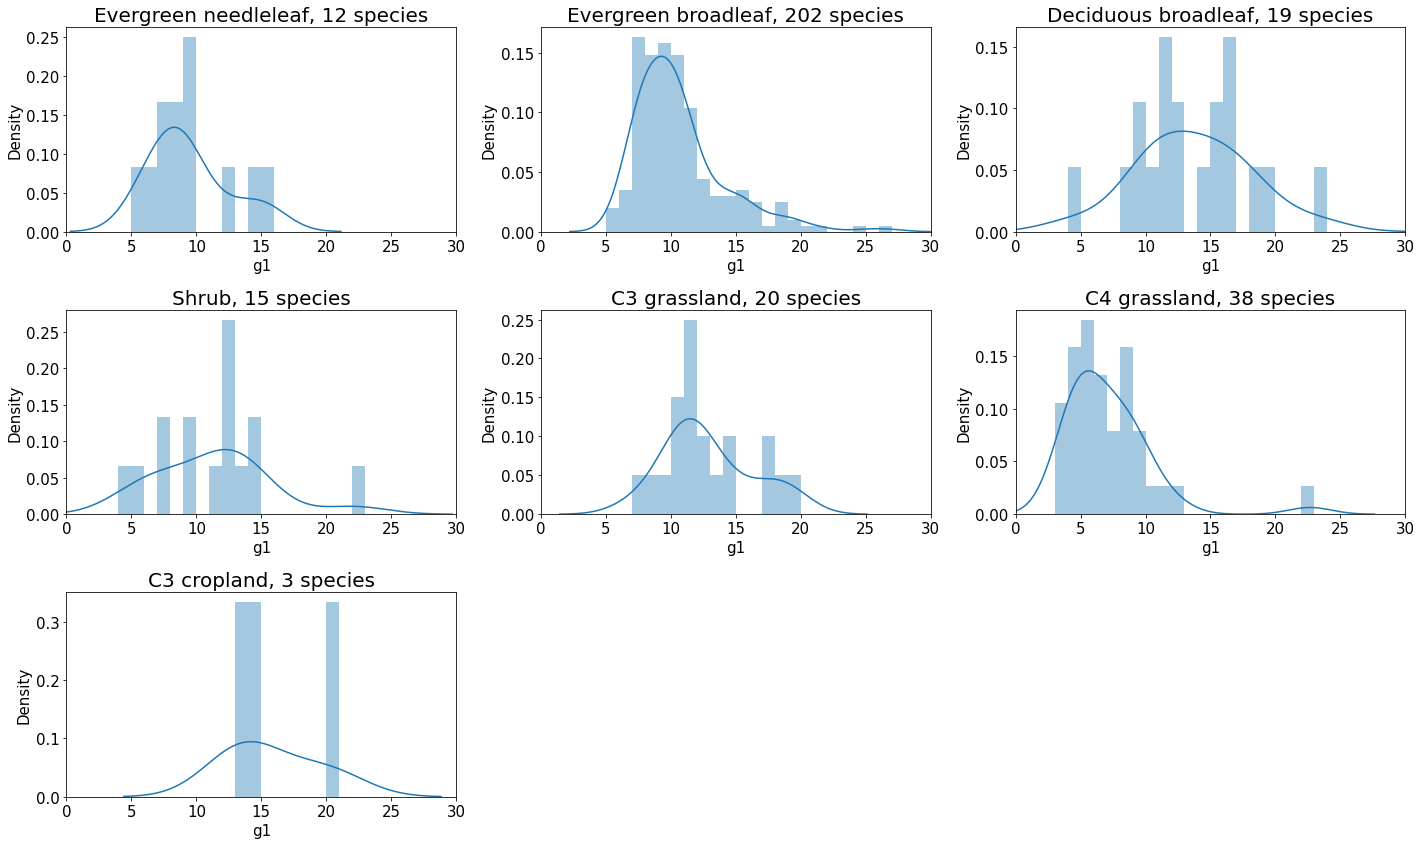

In [78]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 15})
replicate_cutoff = 0

# ----------------------- Use this if grouping by PFT category (broader categorization, used in CLM)
# This is the approach we take for selecting range for model experiments
plt.figure(figsize=[20,12])
for j, PFT_category in enumerate(PFT_categories):
    df_subset = df_BB[df_BB['PFT_category']==PFT_category]
    plttitle=PFT_category
    plt.subplot(3,3,j+1)
# ------------------------------------------------------------------------------------------

# ----------------------- Use this if grouping by PFT (more narrow categorization)
#plt.figure(figsize=[12,9])
#for j, PFT_num in enumerate(PFT_nums):
#    df_subset = df[df['PFT_num']==PFT_num]
#    plttitle=PFTs[j]+' ('+str(PFT_num)+')'
#    plt.subplot(4,4,j+1)
# ------------------------------------------------------------------------------------------
    
    df_subset_species = df_subset.groupby('Species').mean()

    g1s = np.zeros(len(df_subset_species))
    g1s_se = np.zeros(len(df_subset_species))
    xvals_mean = np.zeros(len(df_subset_species))
    yvals_fit = np.zeros(len(df_subset_species))
    g1s[:] = np.nan
    g1s_se[:] = np.nan
    xvals_mean[:] = np.nan
    yvals_fit[:] = np.nan
    count_missing_replicates = 0
    num_replicates_not_counted = 0
    num_replicates_counted = 0

    for i, species in enumerate(df_subset_species.index):
        df_subset_1species = df_subset[df_subset['Species']==species]
        xvals_subset = df_subset_1species['xvals_BB']
        yvals_subset = df_subset_1species['yvals_BB']
        num_replicates = np.size(xvals_subset)

        # Fit model
        model = sm.OLS(yvals_subset, xvals_subset)
        results = model.fit()
        params = results.params
        predictions = model.predict(params)

        if num_replicates<replicate_cutoff:
            g1s[i]=np.nan
            g1s_se[i]=np.nan
            count_missing_replicates = count_missing_replicates + 1
            num_replicates_not_counted = num_replicates_not_counted + num_replicates
            last_ind_skipped = i
        else:
            g1s[i]=params[0]
            g1s_se[i]=results.bse[0]
            xvals_mean[i] = np.nanmean(xvals_subset)
            yvals_fit[i] = np.nanmean(predictions)
            num_replicates_counted = num_replicates_counted + num_replicates
        
    df_subset_species['g1']=g1s
    df_subset_species['g1_se']=g1s_se
    df_subset_species['xvals_mean']=xvals_mean
    df_subset_species['yvals_fit']=yvals_fit
    
    #pft_min = np.nanmin(df_subset_species['g1'].values)
    pft_min = np.nanpercentile(df_subset_species['g1'].values, 5)
    pft_10min = np.nanpercentile(df_subset_species['g1'].values, 10)
    pft_mean = np.nanmean(df_subset_species['g1'].values)
    pft_median = np.nanmedian(df_subset_species['g1'].values)
    #pft_max = np.nanmax(df_subset_species['g1'].values)
    pft_90max = np.nanpercentile(df_subset_species['g1'].values, 90)
    pft_max = np.nanpercentile(df_subset_species['g1'].values, 95)

    # Make subplot
    output = sns.distplot(df_subset_species['g1'].values, bins=np.arange(0,50,1))#, inner='stick')#,cut=2)
    plt.xlim([0, 30])
    plt.xlabel('g1')
    plt.title(plttitle+', '+str(len(df_subset_species)-count_missing_replicates)+' species', fontsize=20)
        
    # Print Summary
    print('--------------')
    print(plttitle)
    print(str(np.size(df_subset['Species'].unique()))+' species')
    print(str(count_missing_replicates)+' species w/not enough replicates')
    print(str(num_replicates_counted)+' measurements counted')
    print(str(num_replicates_not_counted)+' measurements not counted (b/c not enough replicates)')
    print('5th percentile: '+str(np.round(pft_min,2)))
    print('Mean: '+str(np.round(pft_mean,2)))
    #print('PFT Mean: '+str(np.round(PFT_avgs[j], 2)))
    print('95th percentile: '+str(np.round(pft_max,2)))
plt.tight_layout()
plt.savefig('Histograms.png')

In [ ]:
import seaborn as sns

plt.rcParams.update({'font.size': 20})
replicate_cutoff = 0

# ----------------------- Use this if grouping by PFT category (broader categorization, used in CLM)
# This is the approach we take for selecting range for model experiments
plt.figure(figsize=[20,12])
for j, PFT_category in enumerate(PFT_categories):
    df_subset = df_BB[df_BB['PFT_category']==PFT_category]
    plttitle=PFT_category
    plt.subplot(3,3,j+1)
    
    df_subset_species = df_subset.groupby('Species').mean()

    g1s = np.zeros(len(df_subset_species))
    g1s_se = np.zeros(len(df_subset_species))
    xvals_mean = np.zeros(len(df_subset_species))
    yvals_fit = np.zeros(len(df_subset_species))
    g1s[:] = np.nan
    g1s_se[:] = np.nan
    xvals_mean[:] = np.nan
    yvals_fit[:] = np.nan
    count_missing_replicates = 0
    num_replicates_not_counted = 0
    num_replicates_counted = 0

    for i, species in enumerate(df_subset_species.index):
        df_subset_1species = df_subset[df_subset['Species']==species]
        xvals_subset = df_subset_1species['xvals_BB']
        yvals_subset = df_subset_1species['yvals_BB']
        num_replicates = np.size(xvals_subset)

        # Fit model
        model = sm.OLS(yvals_subset, xvals_subset)
        results = model.fit()
        params = results.params
        predictions = model.predict(params)

        if num_replicates<replicate_cutoff:
            g1s[i]=np.nan
            g1s_se[i]=np.nan
            count_missing_replicates = count_missing_replicates + 1
            num_replicates_not_counted = num_replicates_not_counted + num_replicates
            last_ind_skipped = i
        else:
            g1s[i]=params[0]
            g1s_se[i]=results.bse[0]
            xvals_mean[i] = np.nanmean(xvals_subset)
            yvals_fit[i] = np.nanmean(predictions)
            num_replicates_counted = num_replicates_counted + num_replicates
        
    df_subset_species['g1']=g1s
    df_subset_species['g1_se']=g1s_se
    df_subset_species['xvals_mean']=xvals_mean
    df_subset_species['yvals_fit']=yvals_fit
    
    #pft_min = np.nanmin(df_subset_species['g1'].values)
    pft_min = np.nanpercentile(df_subset_species['g1'].values, 5)
    pft_10min = np.nanpercentile(df_subset_species['g1'].values, 10)
    pft_mean = np.nanmean(df_subset_species['g1'].values)
    pft_median = np.nanmedian(df_subset_species['g1'].values)
    #pft_max = np.nanmax(df_subset_species['g1'].values)
    pft_90max = np.nanpercentile(df_subset_species['g1'].values, 90)
    pft_max = np.nanpercentile(df_subset_species['g1'].values, 95)

    # Make subplot
    output = sns.distplot(df_subset_species['g1'].values, bins=20)#, inner='stick')#,cut=2)
    plt.xlim([0, 30])
    plt.xlabel('g1')
    plt.title(plttitle+', '+str(len(df_subset_species)-count_missing_replicates)+' species', fontsize=20)
        
    # Print Summary
    print('--------------')
    print(plttitle)
    print(str(np.size(df_subset['Species'].unique()))+' species')
    print(str(count_missing_replicates)+' species w/not enough replicates')
    print(str(num_replicates_counted)+' measurements counted')
    print(str(num_replicates_not_counted)+' measurements not counted (b/c not enough replicates)')
    print('5th percentile: '+str(np.round(pft_min,2)))
    print('Mean: '+str(np.round(pft_mean,2)))
    #print('PFT Mean: '+str(np.round(PFT_avgs[j], 2)))
    print('95th percentile: '+str(np.round(pft_max,2)))
plt.tight_layout()
plt.savefig('Histograms.png')

In [16]:
df_BB['mbbopt'] = df_BB['yvals_BB']/df_BB['xvals_BB']

/global/homes/c/czarakas/.conda/envs/model_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


KeyError: 'mbbopt'

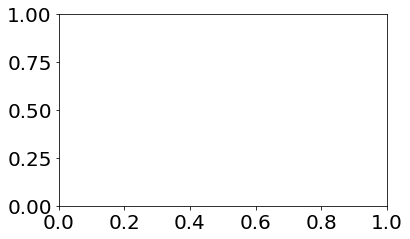

In [105]:
import seaborn as sns

plt.rcParams.update({'font.size': 20})
replicate_cutoff = 0

ibins = np.arange(0,50,1)

# ----------------------- Use this if grouping by PFT category (broader categorization, used in CLM)
# This is the approach we take for selecting range for model experiments
plt.figure(figsize=[20,12])
for j, PFT_category in enumerate(PFT_categories):
    df_subset = df_BB[df_BB['PFT_category']==PFT_category]
    plttitle=PFT_category
    plt.subplot(3,3,j+1)

    output = sns.histplot(df_subset['mbbopt'].values, bins=ibins)
    plt.xlim([0, 40])
    plt.title(plttitle)
    
    print(PFT_category)
    print(np.nanmean(df_subset['mbbopt'].values))
    print(np.nanmedian(df_subset['mbbopt'].values))
plt.tight_layout()
plt.savefig('Histograms.png')

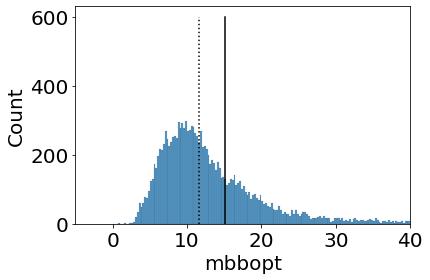

In [76]:
sns.histplot(df_BB['mbbopt'], bins=np.arange(0,100,0.25))
plt.xlim([-5,40])
plt.plot([np.nanmean(df_BB['mbbopt']),np.nanmean(df_BB['mbbopt'])],
         [0,600],'-k')
plt.plot([np.nanmedian(df_BB['mbbopt']),np.nanmedian(df_BB['mbbopt'])],
         [0,600],':k')